In [ ]:
# Upload file json token API
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"fiamaraa","key":"3609e86d7d5f3e6ace8c6b04544aa9de"}'}

In [ ]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
# Download dataset dari kaggle menggunakan API
! kaggle datasets download -d viratkothari/animal10

100% 582M/585M [00:05<00:00, 103MB/s]
100% 585M/585M [00:05<00:00, 121MB/s]


In [ ]:
# Import library yang dibutuhkan
import tensorflow as tf
import keras_preprocessing
from keras_preprocessing import image
from keras_preprocessing.image import ImageDataGenerator
import os
import zipfile
import shutil

In [ ]:
# Unzip file
local_zip = '/content/animal10.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/content/')
zip_ref.close()

In [ ]:
main_dir = os.path.join('/content/Animals-10')
print(os.listdir(main_dir))

['horse', 'dog', 'cat', 'chicken', 'butterfly', 'cow', 'squirrel', 'spider', 'sheep', 'elephant']


In [ ]:
# Menghapus folder yang tidak dibutuhkan
ignore_dir = ['horse', 'cat', 'butterfly', 'cow', 'squirrel', 'sheep', 'elephant']

for dir in ignore_dir:
  path = os.path.join(main_dir, dir)
  shutil.rmtree(path)

print(os.listdir(main_dir))

['dog', 'chicken', 'spider']


In [ ]:
# Menampilkan ukuran dan jumlah sampel
from PIL import Image
samples = 0

for x in os.listdir(main_dir):
  dir = os.path.join('/content/Animals-10', x)
  y = len(os.listdir(dir))
  print(x+':', y)
  samples = samples + y
  
  image_name = os.listdir(dir)
  for z in range(3):
    image_path = os.path.join(dir, image_name[z])
    image = Image.open(image_path)
    print('-',image.size)
  print('\n')


print('\nTotal sampel:', samples)

dog: 4863
- (300, 225)
- (254, 300)
- (300, 240)


chicken: 3098
- (300, 286)
- (300, 225)
- (300, 207)


spider: 4821
- (300, 164)
- (300, 201)
- (300, 201)



Total sampel: 12782


In [ ]:
# Augmentasi gambar yang dilakukan dengan objek ImageDataGenerator dan membagi dataset validasi sebesar 20%
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    horizontal_flip=True,
    shear_range = 0.2,
    zoom_range = 0.2,
    fill_mode = 'nearest',
    validation_split = 0.2)

In [ ]:
train_generator = train_datagen.flow_from_directory(
    main_dir,
    target_size=(150, 150),
    batch_size=128,
    class_mode='categorical',
    subset='training')
 
validation_generator = train_datagen.flow_from_directory(
    main_dir,
    target_size=(150, 150),
    batch_size=128,
    class_mode='categorical',
    subset='validation')

Found 10227 images belonging to 3 classes.
Found 2555 images belonging to 3 classes.


In [ ]:
# membangun model CNN untuk klasifikasi gambar menggunakan model sequential dan Conv2D Maxpooling Layer.
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(150, 150, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(3, activation='softmax')
])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 15, 15, 128)      

In [ ]:
# Memanggil fungsi compile pada objek model dan menentukan loss function serta optimizer
model.compile(optimizer=tf.optimizers.Adam(),
              loss='categorical_crossentropy',
              metrics = ['accuracy'])

In [ ]:
# Penggunaan callbacks
class Callback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('accuracy') > 0.92 and logs.get('val_accuracy') > 0.85):
      print("Training dihentikan karena akurasi pada training set sudah mencapai 0.92 dan validation set sudah mencapai 0.85")
      self.model.stop_training = True

callbacks = Callback()

In [ ]:
# Melatih model dengan menggunakan metode fit
history = model.fit(
    train_generator,
    epochs=50,
    validation_data=validation_generator,
    verbose=2,
    callbacks=[callbacks])

Epoch 1/50
80/80 - 484s - loss: 0.9393 - accuracy: 0.5513 - val_loss: 0.6832 - val_accuracy: 0.7100
Epoch 2/50
80/80 - 486s - loss: 0.6444 - accuracy: 0.7319 - val_loss: 0.5859 - val_accuracy: 0.7632
Epoch 3/50
80/80 - 485s - loss: 0.5079 - accuracy: 0.8059 - val_loss: 0.4511 - val_accuracy: 0.8387
Epoch 4/50
80/80 - 482s - loss: 0.3846 - accuracy: 0.8529 - val_loss: 0.4175 - val_accuracy: 0.8431
Epoch 5/50
80/80 - 484s - loss: 0.3689 - accuracy: 0.8627 - val_loss: 0.4300 - val_accuracy: 0.8341
Epoch 6/50
80/80 - 485s - loss: 0.3223 - accuracy: 0.8794 - val_loss: 0.4212 - val_accuracy: 0.8474
Epoch 7/50
80/80 - 483s - loss: 0.3117 - accuracy: 0.8812 - val_loss: 0.3555 - val_accuracy: 0.8654
Epoch 8/50
80/80 - 482s - loss: 0.2680 - accuracy: 0.9022 - val_loss: 0.3172 - val_accuracy: 0.8845
Epoch 9/50
80/80 - 481s - loss: 0.2680 - accuracy: 0.8990 - val_loss: 0.3130 - val_accuracy: 0.8834
Epoch 10/50
80/80 - 481s - loss: 0.2432 - accuracy: 0.9100 - val_loss: 0.2990 - val_accuracy: 0.8920

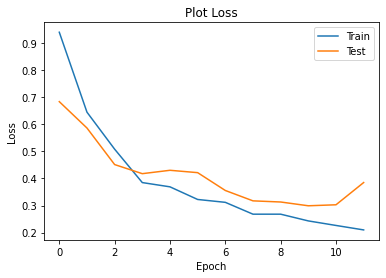

In [ ]:
# Visualisasi plot loss saat training dan validation
import matplotlib.pyplot as plt
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Plot Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper right')
plt.show()

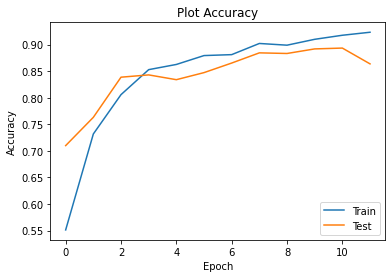

In [ ]:
# Visualisasi plot accuracy saat training dan validation
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Plot Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='lower right')
plt.show()

In [ ]:
# Konversi model
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

INFO:tensorflow:Assets written to: /tmp/tmpwa9k9zld/assets


In [ ]:
# Menyimpan TFlite Model
with open('model.tflite', 'wb') as f:
  f.write(tflite_model)

In [ ]:
Sumber dataset: https://www.kaggle.com/viratkothari/animal10?select=Animals-10